## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
#Подключим необходимые библиотеки для проекта
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
class DataScience:

    def rmse(self,predictions, targets): 
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    
    def plot_feature_importance(self,importance,names,model_type):

        feature_importance = np.array(importance)
        feature_names = np.array(names)

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

        #Define size of bar plot
        plt.figure(figsize=(10,8))
        #Plot Searborn bar chart
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        #Add chart labels
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')
        
        
ds = DataScience()

In [3]:
#Откроем файл с данными. 
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
#выведем первые 5 строк
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
#Проверим наличие пустых значений
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
#Проверим упорядочен ли наш index
print(df.index.is_monotonic)

True


# 2. Анализ

In [8]:
#Проведем ресемплирование по 1 часу, неделе и месяцу
monthly_stat= df.resample('1M').sum()
weekly_stat = df.resample('1W').sum()
hourly_stat = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

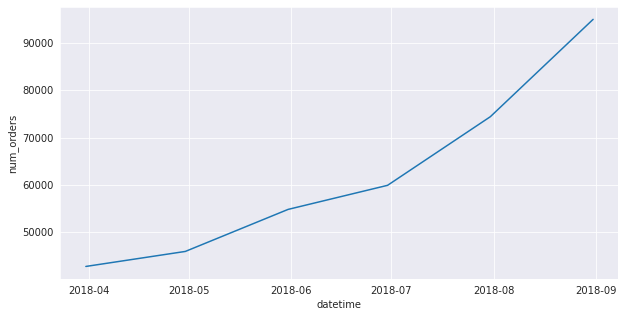

In [9]:
#Посмотрим на статистику заказов в разбивке по месяцам
sns.lineplot(x=monthly_stat.index,y=monthly_stat['num_orders'])

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

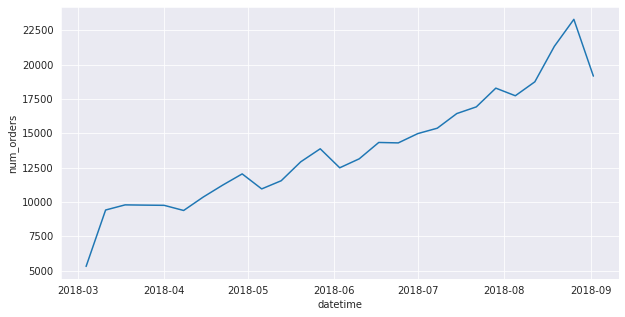

In [10]:
#Посмотрим на статистику заказов в разбивке по неделям
sns.lineplot(x=weekly_stat.index,y=weekly_stat['num_orders'])

<AxesSubplot:xlabel='datetime'>

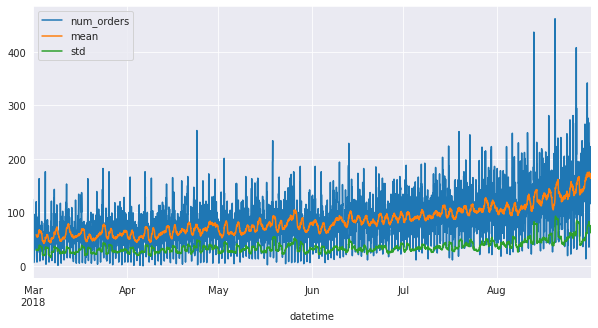

In [11]:
#Посмотрим на скользящее среднее и скользящее стандартное отклонение
hourly_stat['mean'] = hourly_stat['num_orders'].rolling(25).mean()
hourly_stat['std'] = hourly_stat['num_orders'].rolling(25).std()
hourly_stat.plot()

In [12]:
#Сделаем копию датасета чтобы провести анализ
df_copy = df.copy()
df_copy = df_copy.resample('1H').sum()
df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(12).mean()
df_copy['std'] = df_copy['num_orders'].rolling(12).std()
df_copy = df_copy.dropna()

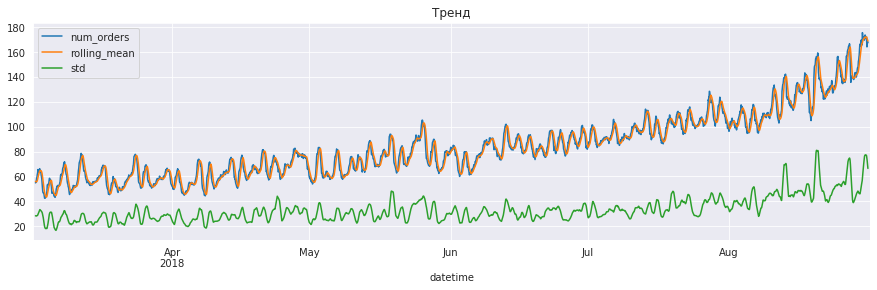

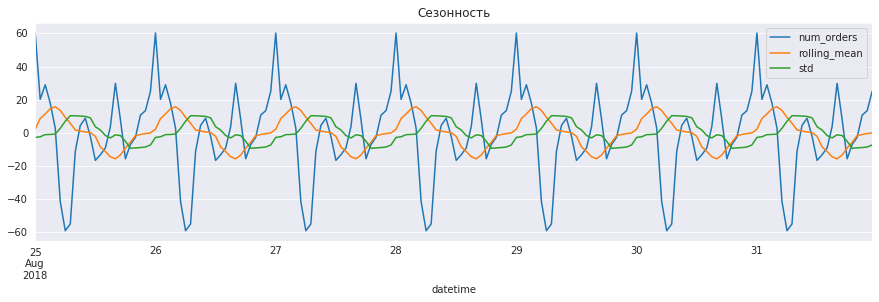

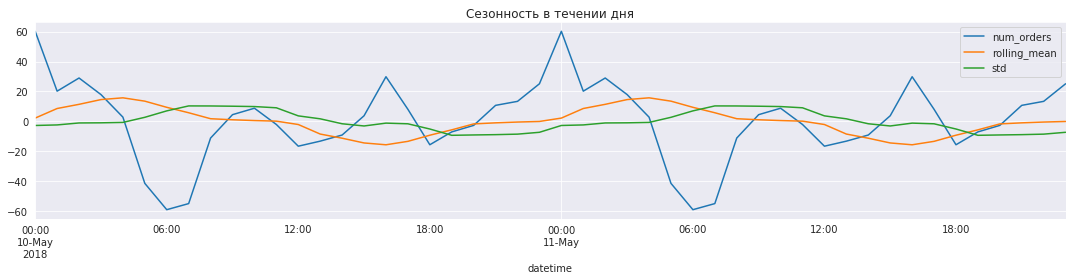

In [33]:
#
decomposed_df = seasonal_decompose(df_copy)
decomposed_df.trend.plot(title='Тренд', figsize=(15,4))
decomposed_df.seasonal.tail(24*7).plot(title='Сезонность', figsize=(15,4))
plt.figure(figsize=(15, 4))
decomposed_df.seasonal['2018-05-10':'2018-05-11'].plot(ax=plt.gca(), figsize=(15,4))
plt.title('Сезонность в течении дня')
plt.tight_layout()

### Вывод: 

- На графике "Тренд" можно увидеть, что количество заказов постепенно увеличивается.
- На графике сезонность разбитое на неделю видно, как количество заказов по выходным меньше чем в другие дни
- На третьем графике количество заказов к утру намного меньше, чем в другое время

# 3. Обучение

In [13]:
#выполним ресемплирование по одному часу
df = df.resample('1H').sum()

#Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 9, 9)

In [14]:
df.describe()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
count,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4408.000000,4407.000000,4407.000000
mean,84.422781,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.236162,84.228954,84.320198
std,45.023853,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,44.831888,44.834421,30.263125
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.888889
25%,54.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.555556
50%,78.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.888889
75%,107.000000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.111111
max,462.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,223.111111


In [15]:
#Разделим нашу таблилцу на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [16]:
#Определим признаки и целевой признак у обучающей и тестовой выборк
X = train.drop(['num_orders'], axis=1)
y = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

In [17]:
#Проверим правильно ли расположены временные даннные, нельзя допустить в обучающую выборку данные из будущего
display(train.head(3))
display(test.head(3))

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 09:00:00,69,3,9,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,50.666667
2018-03-01 10:00:00,64,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,44.555556
2018-03-01 11:00:00,96,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,42.222222


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,103.000000
2018-08-13 15:00:00,175,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,105.111111
2018-08-13 16:00:00,144,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,117.222222


In [18]:
#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(X.shape[0], X.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размер обучающей выборки: 3965 объектов, 12 признаков
Размер тестовой выборки: 442 объектов, 12 признаков


### LinearRegression

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(n_jobs=-1)
lr.fit(X,y)
lr_predictions = lr.predict(X_test)
print('RMSE:', ds.rmse(lr_predictions,y_test))

RMSE: 54.08758434757491


In [20]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [21]:
#Попробуем подобрать параметры с помощью цикла

estimators = [50,100,200,300]
forleaves = [2,5,7,12]


for estim, leaves in zip(estimators, forleaves):
    lgb_model = lgb.LGBMRegressor(n_estimators=estim, num_leaves=leaves)
    lgb_model.fit(X,y)
    predictions = lgb_model.predict(X)
    print('RMSE with n_estimators : {} and num_leaves: {} is {}'.format(estim, leaves, ds.rmse(predictions, y)))

RMSE with n_estimators : 50 and num_leaves: 2 is 29.447685769072727
RMSE with n_estimators : 100 and num_leaves: 5 is 22.159400472645576
RMSE with n_estimators : 200 and num_leaves: 7 is 19.212092776098753
RMSE with n_estimators : 300 and num_leaves: 12 is 14.89407898647034


In [24]:
param_grid = {
    'n_estimators': [50,100,200,300],
    'num_leaves': [2,5,7,12]
}
grid_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=42), 
                    param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', refit=False) 
grid_lgbm.fit(X, y)
params = grid_lgbm.best_params_
lgbm = lgb.LGBMRegressor(**params, random_state = 42)
lgbm.fit(X, y)
pred_test = lgbm.predict(X)
print(params)
print("RMSE на тестовой выборке: ", ds.rmse(y, pred_test))

{'n_estimators': 100, 'num_leaves': 12}
RMSE на тестовой выборке:  19.09385920439177


LightGBM показал лучший результат на обучающей выборке с ним и будем работать дальше

### LightGBMRegressor

# 4. Тестирование

In [22]:
model = lgb.LGBMRegressor(
                          n_estimators=300,
                          num_leaves=12,
                          objective='regression'
)

model.fit(X,y)
predictions = model.predict(X_test)
print('RMSE на тестовой выборке:', ds.rmse(predictions,y_test))

RMSE на тестовой выборке: 43.92340606427539


### Feature Importance

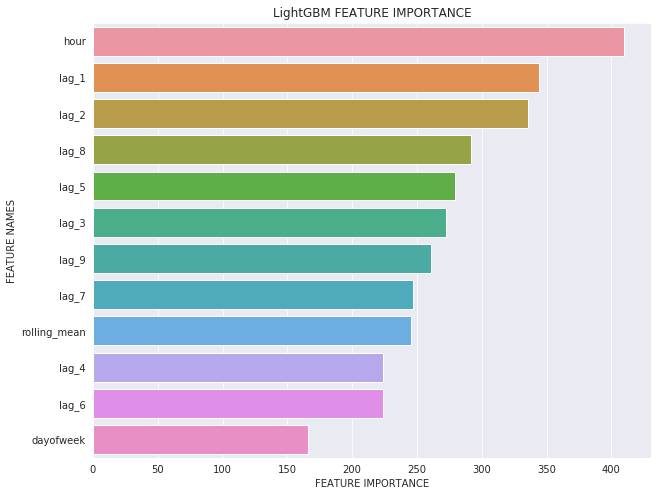

In [24]:
#Посмотрим feature importance у модели lightgbm
ds.plot_feature_importance(model.feature_importances_,X_test.columns,'LightGBM ')

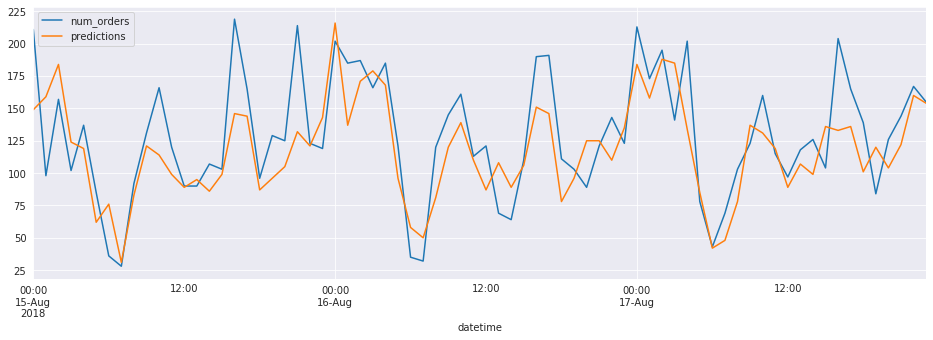

In [28]:
#выведем на графике реальное количество заказов в день и предсказанное нашей моделью. 
graph = y_test.copy()
predictions_taxi = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-15':'2018-08-17'].plot(figsize=(16,5))

Как видно по графику, наша модель достаточно хорошо попадает в реальные заказы. Конечно есть плюс-минус погрешности, которые можно исправить, если хорошо подтюнить модель. Но в целом, считаю, что довольно-таки неплохой результат :) 

### Вывод: 

- Мы получили на выходе результат RMSE На тестовой выборке 41 - выполнили задание
- У меня во время появился вопрос, я вначале начал подбирать параметры с помощью GridSearchCV, но после подумал что с ним нельзя проводить подбор параметров, так как он размешивает данные. Вопрос с мопощью какой сетки можно подбирать параметры из sklearn? :) 